# TikTok Usage Analysis Notebook
This notebook scrapes the Sabancı University academic calendar for holidays, enriches TikTok watch history with day-of-week and time bins, and performs EDA.

## 1. Scrape Holidays from Academic Calendar

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# 1. Map Turkish → English month abbreviations
month_map = {
    'Oca': 'Jan', 'Şub': 'Feb', 'Mar': 'Mar', 'Nis': 'Apr',
    'May': 'May', 'Haz': 'Jun', 'Tem': 'Jul', 'Ağu': 'Aug',
    'Eyl': 'Sep', 'Eki': 'Oct', 'Kas': 'Nov', 'Ara': 'Dec'
}
dash_re = re.compile(r'\s*[\u2013\u2014-]\s*')  # matches hyphen, en‐dash, em‐dash

def replace_months(text):
    for tr, en in month_map.items():
        text = re.sub(rf'\b{tr}\b', en, text)
    return text

def parse_range(range_str):
    txt = range_str.strip()
    # Multi‐day range?
    if dash_re.search(txt):
        start_raw, end_raw = dash_re.split(txt, maxsplit=1)
        # Normalize Turkish month names
        start_norm = replace_months(start_raw)
        end_norm   = replace_months(end_raw)
        # If start lacks year, borrow from end
        if not re.search(r'\d{4}', start_norm):
            m = re.search(r'([A-Za-z]+)\s+(\d{4})', end_norm)
            if m:
                month, year = m.groups()
                start_norm = f"{start_norm} {month} {year}"
        # Parse and expand
        start_dt = pd.to_datetime(start_norm, dayfirst=True)
        end_dt   = pd.to_datetime(end_norm,   dayfirst=True)
        return pd.date_range(start_dt, end_dt).date.tolist()
    else:
        # Single‐day entry
        norm = replace_months(txt)
        dt   = pd.to_datetime(norm, dayfirst=True)
        return [dt.date()]

# 2. Fetch & parse
url  = 'https://apps.sabanciuniv.edu/custom/academic-calendar/?a=0&b=2024&c=14&d=tr&e=0'
resp = requests.get(url)
soup = BeautifulSoup(resp.content, 'html.parser')

# 3. Extract all “tatil” rows
holidays = []
for row in soup.select('tr'):
    tds = row.find_all('td', class_='yeniIcerik')
    if not tds:
        continue
    title = tds[0].get_text(strip=True).lower()
    if 'tatil' in title:
        for td in tds[1:]:
            span = td.find('span')
            txt  = span.get_text(strip=True) if span else ''
            if txt:
                holidays.extend(parse_range(txt))

# 4. Dedupe & sort
holiday_df = pd.DataFrame({'date': sorted(set(holidays))})
display(holiday_df)


,date


## 2. Load and Prepare TikTok Data

In [4]:
import json
import pandas as pd

# 1. Load the raw JSON
with open('user_data_tiktok.json', 'r') as f:
    raw = json.load(f)

# 2. Drill down into “Your Activity” and find which sub‐dict has a list
activity = raw.get("Your Activity", {})
for section, content in activity.items():
    if isinstance(content, dict):
        for key, value in content.items():
            if isinstance(value, list):
                print(f"Found list at Your Activity → {section} → {key}")
# e.g. “Found list at Your Activity → Login History → LoginHistoryList”

# 3. Pick the one you want (here LoginHistoryList)
data_list = activity["Login History"]["LoginHistoryList"]

# 4. Normalize into DataFrame
df = pd.json_normalize(data_list)

# 5. Parse the “Date” column to a true datetime
df['timestamp'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

# 6. Feature engineering exactly as before
df['day_of_week'] = df['timestamp'].dt.day_name()

def time_bin(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['time_bin'] = df['timestamp'].dt.hour.apply(time_bin)

# 7. Flag holidays (using your holiday_df)
df['date']       = df['timestamp'].dt.date
df['is_holiday'] = df['date'].isin(holiday_df['date'])

# 8. Preview
display(df.head())


Found list at Your Activity → Login History → LoginHistoryList
Found list at Your Activity → Searches → SearchList
Found list at Your Activity → Share History → ShareHistoryList
Found list at Your Activity → Status → Status List
Found list at Your Activity → Watch History → VideoList


,Date,IP,DeviceModel,DeviceSystem,NetworkType,Carrier,timestamp,day_of_week,time_bin,date,is_holiday
0,2024-10-20 03:20:12,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:20:12,Sunday,Night,2024-10-20,False
1,2024-10-20 03:20:26,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:20:26,Sunday,Night,2024-10-20,False
2,2024-10-20 03:27:40,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:27:40,Sunday,Night,2024-10-20,False
3,2024-10-20 06:59:39,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 06:59:39,Sunday,Morning,2024-10-20,False
4,2024-10-20 07:15:36,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 07:15:36,Sunday,Morning,2024-10-20,False


## 3. Exploratory Data Analysis (EDA)

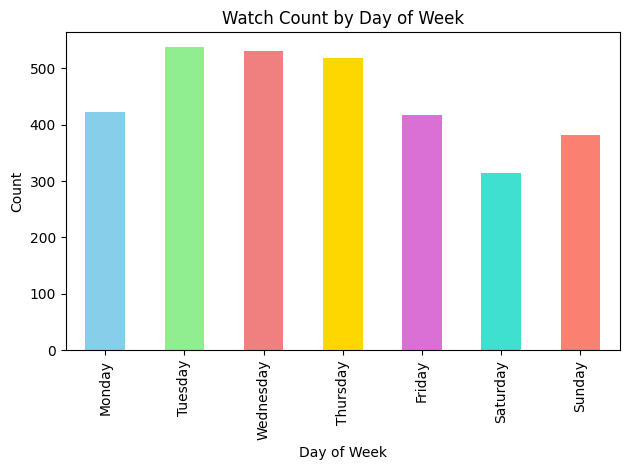

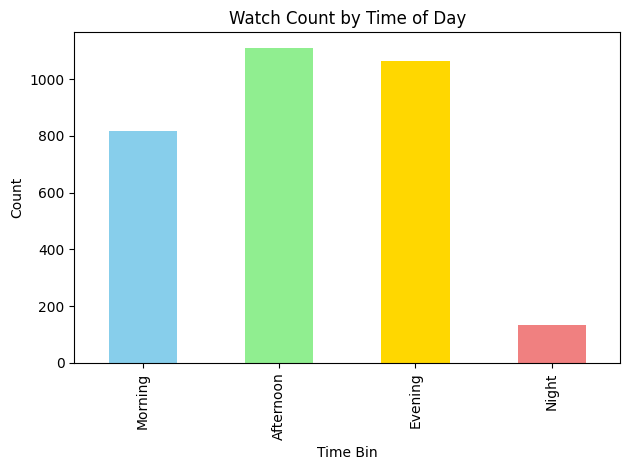

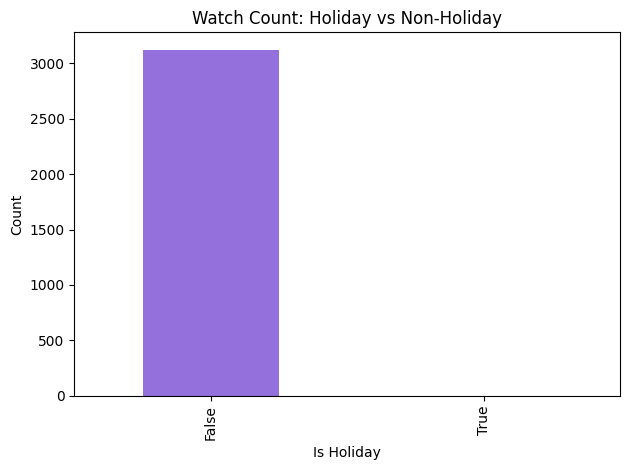

In [7]:
import matplotlib.pyplot as plt

# 1) Watch count by day of week
counts = df['day_of_week'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
# pastel‐inspired 7-color palette
colors_dow = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'turquoise', 'salmon']
counts.plot(kind='bar', color=colors_dow)
plt.title('Watch Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 2) Watch count by time bin
time_order = ['Morning','Afternoon','Evening','Night']
time_counts = df['time_bin'].value_counts().reindex(time_order)
# soft 4-color palette
colors_tb = ['skyblue', 'lightgreen', 'gold', 'lightcoral']
time_counts.plot(kind='bar', color=colors_tb)
plt.title('Watch Count by Time of Day')
plt.xlabel('Time Bin')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 3) Watch count: holiday vs non‐holiday
hol_order = [False, True]
holiday_counts = df['is_holiday'].value_counts().reindex(hol_order)
# contrasting 2-color pair
colors_h = ['mediumpurple', 'lightseagreen']
holiday_counts.plot(kind='bar', color=colors_h)
plt.title('Watch Count: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
